In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from Configs import getEnvConfig, visualizeEnvConfig, getPredictorConfig, visualizePredictorConfig
from EnvLibs import PolicySimulator, createEnv
from DiffusionLibs import DiffusionPolicyInterface
from MdpSolverLibs import MdpKernel

In [2]:
configIdx = 0
envParams = getEnvConfig(configIdx)
visualizeEnvConfig(envParams)
predictorParams = getPredictorConfig(configIdx)
visualizePredictorConfig(predictorParams)
trafficDataParentPath = f'Results/TrafficData'
env = createEnv(envParams, trafficDataParentPath)
env.selectMode(mode="train", type="data")

Environment Configuration
Number of Users:        4
Window Length:          200
Dataflow:               thumb_fr
N_aggregation:          4
Resource Bar:           5
Bandwidth:              100
M List:                 [3, 4, 5]
Random Seed:            999
Alpha Range:            (0.01, 1.0)
Discrete Alpha Steps:   10
Predictor Configuration
Window Length:          200
Upsample K:             10
Dataflow:               thumb_fr
DB Parameter:           0.001
Alpha:                  0.01
Mode:                   fixed
Direction:              forward
Train Ratio:            0.6
Train Data Augment:     False
Smooth Fc:              1.5
Smooth Order:           3


In [16]:
#with open(f'Results/DiffusionQ_dataset/dataset_01.pkl', 'rb') as f:
#    dataset_01 = pickle.load(f)
#with open(f'Results/DiffusionQ_dataset/dataset_02.pkl', 'rb') as f:
#    dataset_02 = pickle.load(f)
with open(f'Results/DiffusionQ_dataset/config{configIdx}_dataset_02.pkl', 'rb') as f:
    dataset = pickle.load(f)
#with open(f'Results/DiffusionQ_dataset/dataset_04.pkl', 'rb') as f:
#    dataset = pickle.load(f)
print(f"Size of dataset: {len(dataset['uRecord'])}")

dataset_offlineRL = (dataset['uRecord'], dataset['actionsRecord'], dataset['rewardRecord'], dataset['uNextRecord'])

Size of dataset: 20000


In [20]:
diffusionQParams = {
    'device': 'cuda',
    'gamma': 0.99,
    'tau': 0.005,
    'lr': 5e-4,
    'Lq_weight': 1.0,
    'Ld_weight': 1.0,
    'iql_tau': 0.9,
    'temperature': 5.0,
    'N_action_candidates': 50
}

diffusionPolicyInterface = DiffusionPolicyInterface(envParams, **diffusionQParams)
model_state_dict, info = diffusionPolicyInterface.train(
    dataset_offlineRL, env, iql_flag=True, epochs=500,batch_size=1024, sample_method="greedy")

Evaluation windows: 100%|██████████| 500/500 [00:16<00:00, 30.01it/s]                                                            


Epoch   50/ 500  Avg Ld=0.188936  Avg Lq=5.801663  Avg loss_critic=0.030622  Test packet loss=0.1189  Avg est_reward=2.458039


Evaluation windows: 100%|██████████| 500/500 [00:16<00:00, 30.46it/s]                                                            


Epoch  100/ 500  Avg Ld=0.116388  Avg Lq=0.850485  Avg loss_critic=0.019073  Test packet loss=0.0472  Avg est_reward=6.642310


Evaluation windows: 100%|██████████| 500/500 [00:16<00:00, 30.43it/s]                                                             


Epoch  150/ 500  Avg Ld=0.083443  Avg Lq=0.508145  Avg loss_critic=0.022884  Test packet loss=0.0166  Avg est_reward=10.892516


KeyboardInterrupt: 

In [7]:
# Save the trained model state dictionary
import torch
torch.save(model_state_dict, f'Results/DiffusionQ/diffusionQ_config{configIdx}.pth')
print(f"Model saved to Results/DiffusionQ/diffusionQ_config{configIdx}.pth")
with open(f'Results/DiffusionQ/diffusionQ_info_config{configIdx}.pkl', 'wb') as f:
    pickle.dump(info, f)
print(f"Info saved to Results/DiffusionQ/diffusionQ_info_config{configIdx}.pkl")
with open(f'Results/DiffusionQ/diffusionQ_params_config{configIdx}.pkl', 'wb') as f:
    pickle.dump(diffusionQParams, f)
print(f"Params saved to Results/DiffusionQ/diffusionQ_params_config{configIdx}.pkl")

Model saved to Results/DiffusionQ/diffusionQ_config0.pth
Info saved to Results/DiffusionQ/diffusionQ_info_config0.pkl
Params saved to Results/DiffusionQ/diffusionQ_params_config0.pkl


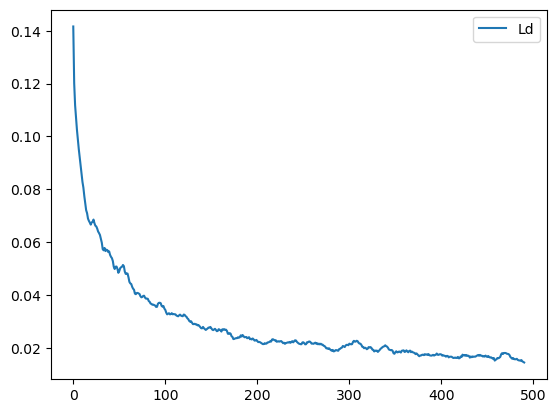

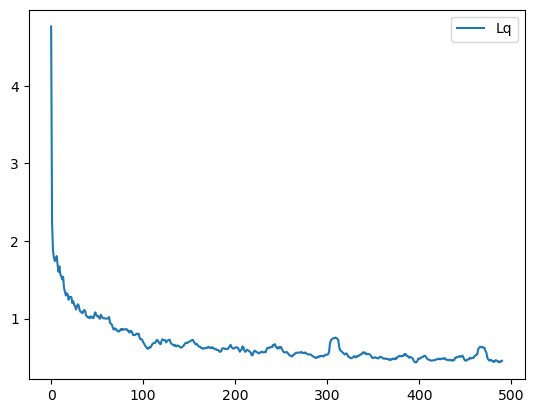

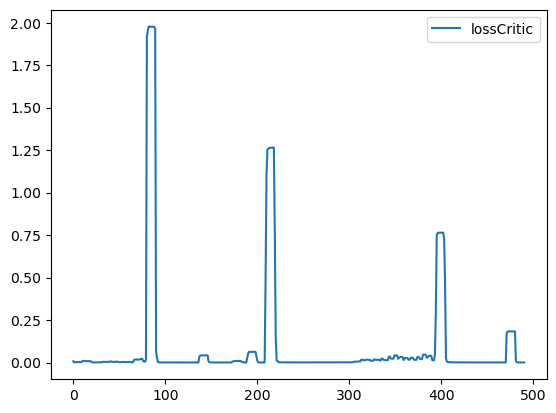

In [8]:
def smooth(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

obv_idxs = -500
window_size = 10
plt.plot(smooth(info['LdRecord'][obv_idxs:], window_size=window_size), label="Ld")
plt.legend()
plt.show()
plt.plot(smooth(info['LqRecord'][obv_idxs:], window_size=window_size), label="Lq")
plt.legend()
plt.show()
plt.plot(smooth(info['lossCriticRecord'][obv_idxs:], window_size=window_size), label="lossCritic")
plt.legend()
plt.show()